In [1]:
%load_ext autoreload
%autoreload 2


from deepgreen import *
import pandas as pd
import json
from dotenv import load_dotenv
import os

from sentinelhub.api.catalog import SentinelHubCatalog

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    BBoxSplitter,
    CustomGridSplitter,
    OsmSplitter,
    TileSplitter,
    UtmGridSplitter,
    UtmZoneSplitter,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    read_data,
    bbox_to_dimensions,
)
from utils import plot_image

In [ ]:
# Init Config
load_dotenv()

CONFIG = SHConfig()
# TODO: Gaht nöd
CONFIG.sh_client_id = ''
CONFIG.sh_client_secret = '''
# Init Catalog
CATALOG = SentinelHubCatalog(config=CONFIG)

In [129]:
aoi = BBox(((8.396073, 47.46039533333333), (8.557649333333332, 47.562627)), crs=CRS('4326'))

In [130]:
df_cc = pd.read_csv('test_aoi.csv', 
                    sep = ",", 
                    dtype={
                        'AOI_ID': 'string',
                        'Timestamp': 'string',
                        'CC_API': 'float64',
                        'CC_CLC': 'float64'})
df_cc = df_cc.drop(columns=['Unnamed: 0'])
df_cc['Date'] = df_cc['Timestamp'].apply(lambda x: x.split('T')[0])
df_cc = df_cc[['AOI_ID', 'Date', 'Timestamp', 'CC_API', 'CC_CLC']]
df_cc

,AOI_ID,Date,Timestamp,CC_API,CC_CLC
0,0000,2025-04-03,2025-04-03T10:37:44Z,30.02,11.565745
1,0000,2025-03-31,2025-03-31T10:37:55Z,74.31,77.620825
2,0000,2025-03-31,2025-03-31T10:27:49Z,82.82,77.620825
3,0000,2025-03-29,2025-03-29T10:38:07Z,99.72,100.000000
4,0000,2025-03-28,2025-03-28T10:27:57Z,81.49,6.144761
...,...,...,...,...,...
768,0000,2020-01-12,2020-01-12T10:27:43Z,33.21,93.343024
769,0000,2020-01-10,2020-01-10T10:37:40Z,31.52,65.185287
770,0000,2020-01-07,2020-01-07T10:27:43Z,52.73,84.630600
771,0000,2020-01-05,2020-01-05T10:37:40Z,1.47,10.330404


In [132]:
#api_condition = (df_cc['CC_API'] >= 95) | (df_cc['CC_API'] <= 5)
#clc_condition = (df_cc['CC_CLC'] >= 95) | (df_cc['CC_CLC'] <= 5)
#api_condition = (df_cc['CC_API'] >= 99.9) | (df_cc['CC_API'] <= 0.1)
#clc_condition = (df_cc['CC_CLC'] >= 99.9) | (df_cc['CC_CLC'] <= 0.1)
# Combine the boolean masks using the OR operator
#df_cc_subset = df_cc[api_condition | clc_condition]
df_cc_subset = df_cc

df_cc_subset.sort_values(by = ['CC_API'], ascending= False, inplace=True)
df_cc_subset.reset_index(drop=True, inplace=True)
df_cc_subset

,AOI_ID,Date,Timestamp,CC_API,CC_CLC
0,0000,2021-07-08,2021-07-08T10:37:48Z,99.99,0.000000
1,0000,2020-08-29,2020-08-29T10:27:54Z,99.99,42.338441
2,0000,2022-10-08,2022-10-08T10:27:55Z,99.99,91.424755
3,0000,2022-10-01,2022-10-01T10:37:53Z,99.99,98.104981
4,0000,2022-03-12,2022-03-12T10:27:48Z,99.99,100.000000
...,...,...,...,...,...
768,0000,2024-02-03,2024-02-03T10:37:41Z,0.00,13.818199
769,0000,2021-02-25,2021-02-25T10:27:43Z,0.00,16.667826
770,0000,2021-04-04,2021-04-04T10:37:43Z,0.00,16.950876
771,0000,2024-08-23,2024-08-23T10:27:45Z,0.00,10.748244


In [45]:
df_cc_subset.to_csv('test_aoi_subset.csv', sep = ",", index = False)

In [133]:
df_cc_subset = df_cc_subset[['Timestamp', 'CC_API', 'CC_CLC']]
timestamp_list = df_cc_subset['Timestamp'].to_list()
print(len(timestamp_list))

773


In [135]:
evalscript = load_evalscript("evalscripts/es_standard.js")
resolution = 10
aoi_id = '0000'
aoi_bbox = aoi
idx = 0
for timestamp in timestamp_list:
    idx +=1
    print(f"Downloading Image {idx}/{len(timestamp_list)}")
    img = get_img(evalscript = evalscript, timestamp = str(timestamp)[:10], bbox = aoi_bbox, resolution = resolution, CONFIG = CONFIG)
    image_name = aoi_id+"_"+str(timestamp)[:10]+".png"
    download_img(img = img, path = '/Users/Alex/data/250416_test', filename = image_name)

In [136]:
df_cc_subset['Image_Path'] = df_cc_subset['Timestamp'].apply(lambda x: '/Users/Alex/data/250416_test/' + aoi_id + "_" + str(x)[:10] + ".png")
df_cc_subset = df_cc_subset[['Timestamp', 'CC_API', 'CC_CLC', 'Image_Path']]

/var/folders/nt/2f26v76x6nq__8sxgl9bz2xr0000gn/T/ipykernel_26098/462019702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_subset['Image_Path'] = df_cc_subset['Timestamp'].apply(lambda x: '/Users/Alex/data/250416_test/' + aoi_id + "_" + str(x)[:10] + ".png")


In [76]:
import pandas as pd
from PIL import Image
import io
import base64

def make_html(dataframe, filename="output_table.html"):
    """Creates a styled HTML table with embedded images and saves it to a file."""

    # CSS styling for a clean layout
    style = """
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 40px;
            background-color: #fafafa;
        }
        table {
            border-collapse: collapse;
            width: 100%;
            margin-top: 20px;
            background-color: white;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }
        th, td {
            border: 1px solid #dddddd;
            padding: 10px;
            vertical-align: top;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
        img {
            max-width: 300px;
            height: auto;
            display: block;
        }
        caption {
            caption-side: top;
            font-size: 1.5em;
            font-weight: bold;
            margin-bottom: 10px;
        }
    </style>
    """

    html_table = "<html><head>" + style + "</head><body>"
    html_table += "<table><caption>Data Table with Images</caption><thead><tr>"

    for col in dataframe.columns:
        html_table += f"<th>{col}</th>"
    html_table += "</tr></thead><tbody>"

    for _, row in dataframe.iterrows():
        html_table += "<tr>"
        for col in dataframe.columns:
            if col == 'Image_Path':
                try:
                    img = Image.open(row[col])
                    buffered = io.BytesIO()
                    img.save(buffered, format="PNG")
                    img_str = base64.b64encode(buffered.getvalue()).decode()
                    html_table += f"<td><img src='data:image/png;base64,{img_str}'></td>"
                except FileNotFoundError:
                    html_table += "<td><i>Image not found</i></td>"
                except Exception as e:
                    html_table += f"<td><i>Error: {e}</i></td>"
            else:
                html_table += f"<td>{row[col]}</td>"
        html_table += "</tr>"

    html_table += "</tbody></table></body></html>"

    with open(filename, "w", encoding="utf-8") as f:
        f.write(html_table)

    print(f"✅ HTML table with images saved to: {filename}")


In [137]:
make_html(df_cc_subset, "all_images.html")

✅ HTML table with images saved to: all_images.html


In [139]:
df_cc_subset['CC_Max'] = df_cc_subset[['CC_API', 'CC_CLC']].max(axis=1)
df_cc_subset

,Timestamp,CC_API,CC_CLC,Image_Path,CC_Max
0,2021-07-08T10:37:48Z,99.99,0.000000,/Users/Alex/data/250416_test/0000_2021-07-08.png,99.990000
1,2020-08-29T10:27:54Z,99.99,42.338441,/Users/Alex/data/250416_test/0000_2020-08-29.png,99.990000
2,2022-10-08T10:27:55Z,99.99,91.424755,/Users/Alex/data/250416_test/0000_2022-10-08.png,99.990000
3,2022-10-01T10:37:53Z,99.99,98.104981,/Users/Alex/data/250416_test/0000_2022-10-01.png,99.990000
4,2022-03-12T10:27:48Z,99.99,100.000000,/Users/Alex/data/250416_test/0000_2022-03-12.png,100.000000
...,...,...,...,...,...
768,2024-02-03T10:37:41Z,0.00,13.818199,/Users/Alex/data/250416_test/0000_2024-02-03.png,13.818199
769,2021-02-25T10:27:43Z,0.00,16.667826,/Users/Alex/data/250416_test/0000_2021-02-25.png,16.667826
770,2021-04-04T10:37:43Z,0.00,16.950876,/Users/Alex/data/250416_test/0000_2021-04-04.png,16.950876
771,2024-08-23T10:27:45Z,0.00,10.748244,/Users/Alex/data/250416_test/0000_2024-08-23.png,10.748244


In [143]:
#filter out images with CC > 95
df_cc_subset_filtered = df_cc_subset[df_cc_subset['CC_Max'] <= 20]
df_cc_subset_filtered.sort_values(by = ['Timestamp'], ascending = True, inplace=True)
df_cc_subset_filtered.reset_index(drop=True, inplace=True)
df_cc_subset_filtered

/var/folders/nt/2f26v76x6nq__8sxgl9bz2xr0000gn/T/ipykernel_26098/2581127802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc_subset_filtered.sort_values(by = ['Timestamp'], ascending = True, inplace=True)


,Timestamp,CC_API,CC_CLC,Image_Path,CC_Max
0,2020-01-05T10:37:40Z,1.47,10.330404,/Users/Alex/data/250416_test/0000_2020-01-05.png,10.330404
1,2020-01-15T10:37:39Z,7.86,13.961680,/Users/Alex/data/250416_test/0000_2020-01-15.png,13.961680
2,2020-03-15T10:37:42Z,0.51,12.911177,/Users/Alex/data/250416_test/0000_2020-03-15.png,12.911177
3,2020-03-25T10:37:41Z,5.09,14.396975,/Users/Alex/data/250416_test/0000_2020-03-25.png,14.396975
4,2020-04-01T10:27:44Z,4.39,16.536295,/Users/Alex/data/250416_test/0000_2020-04-01.png,16.536295
...,...,...,...,...,...
117,2024-12-16T10:27:51Z,0.00,10.758891,/Users/Alex/data/250416_test/0000_2024-12-16.png,10.758891
118,2025-03-04T10:37:48Z,2.23,10.208652,/Users/Alex/data/250416_test/0000_2025-03-04.png,10.208652
119,2025-03-06T10:28:13Z,0.00,13.289108,/Users/Alex/data/250416_test/0000_2025-03-06.png,13.289108
120,2025-03-18T10:28:01Z,0.88,15.725965,/Users/Alex/data/250416_test/0000_2025-03-18.png,15.725965


In [191]:
data = df_cc_subset.copy()
data['CC_Diff'] = abs(data['CC_CLC'] - data['CC_API'])
data.sort_values(by = ['CC_Diff'], ascending = False, inplace=True)
data.reset_index(drop=True, inplace=True)




In [197]:
data_subset_1 = data[['Timestamp', 'CC_API', 'CC_CLC', 'CC_Diff', 'Image_Path']].head(100).copy()
data_subset_1['CC_CLC'] = data_subset_1['CC_CLC'].round(2)
data_subset_1['CC_Diff'] = data_subset_1['CC_Diff'].round(2)
data_subset_1


,Timestamp,CC_API,CC_CLC,CC_Diff,Image_Path
0,2021-07-08T10:37:48Z,99.99,0.00,99.99,/Users/Alex/data/250416_test/0000_2021-07-08.png
1,2021-05-06T10:27:47Z,99.99,0.00,99.99,/Users/Alex/data/250416_test/0000_2021-05-06.png
2,2022-08-19T10:28:01Z,99.63,0.00,99.63,/Users/Alex/data/250416_test/0000_2022-08-19.png
3,2021-07-25T10:27:52Z,99.45,0.00,99.45,/Users/Alex/data/250416_test/0000_2021-07-25.png
4,2021-01-14T10:37:45Z,99.12,1.50,97.62,/Users/Alex/data/250416_test/0000_2021-01-14.png
...,...,...,...,...,...
95,2021-03-25T10:37:44Z,81.64,28.32,53.32,/Users/Alex/data/250416_test/0000_2021-03-25.png
96,2023-07-25T10:27:53Z,70.53,17.92,52.61,/Users/Alex/data/250416_test/0000_2023-07-25.png
97,2021-05-09T10:37:44Z,78.08,25.49,52.59,/Users/Alex/data/250416_test/0000_2021-05-09.png
98,2021-07-05T10:27:51Z,99.03,46.77,52.26,/Users/Alex/data/250416_test/0000_2021-07-05.png


In [198]:
make_html(data_subset_1, "top_100_cc_diffs.html")

✅ HTML table with images saved to: top_100_cc_diffs.html


### Videostuff

In [ ]:
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
from moviepy.video.VideoClip import TextClip
from moviepy.video.compositing.CompositeVideoClip import CompositeVideoClip
from moviepy.video.compositing.CompositeVideoClip import concatenate_videoclips
import os

# Load DataFrame and image paths
df = df_cc_subset_filtered.copy()
image_paths = df["Image_Path"].tolist()
timestamps = df["Timestamp"].tolist()

# Settings
fps = 120/122
output_path = "stop_motion_with_timestamps.mp4"

# Create a list to hold composite clips
clips_with_text = []

for img_path, timestamp in zip(image_paths, timestamps):
    # Base image clip
    img_clip = ImageSequenceClip([img_path], durations=[1/fps])
    
    # Create a text clip with the timestamp
    txt_clip = TextClip(
        text=str(timestamp)[:10],
        font_size=24,
        font='/System/Library/Fonts/Supplemental/NotoSansJavanese-Regular.otf',
        color='white',
        stroke_color='black',
        stroke_width=2,
        horizontal_align='right',
        vertical_align='bottom',
        margin = (10,10),
        duration=1/fps
    )
    
    # Combine image and text
    composite = CompositeVideoClip([img_clip, txt_clip])
    
    # Add to our list
    clips_with_text.append(composite)

# Concatenate all frames
final_clip = concatenate_videoclips(clips_with_text, method="compose")

# Write to file
final_clip.write_videofile(output_path, codec='libx264', audio=False)

MoviePy - Building video stop_motion_with_timestamps.mp4.
MoviePy - Writing video stop_motion_with_timestamps.mp4



MoviePy - Done !
MoviePy - video ready stop_motion_with_timestamps.mp4


In [181]:
from moviepy import ImageSequenceClip, CompositeVideoClip, TextClip
import os

# Load the DataFrame (replace this with your actual loading method)
df = df_cc_subset_filtered.copy()

image_paths = df["Image_Path"].tolist()

# Optional: sort by Timestamp if needed
# df = df.sort_values("Timestamp")
# image_paths = df["Image_Path"].tolist()

# Define output settings
fps = (120/122)*2  # Frames per second
output_path = "kuulevideo_120.mp4"

# Create video clip
clip = ImageSequenceClip(image_paths, fps=fps)

# Write to file
clip.write_videofile(output_path, codec='libx264', audio=False)


MoviePy - Building video kuulevideo_120.mp4.
MoviePy - Writing video kuulevideo_120.mp4



MoviePy - Done !
MoviePy - video ready kuulevideo_120.mp4


#### Specific Cases

In [85]:
es_rgb = load_evalscript("evalscripts/es_standard.js")
es_clm = load_evalscript("evalscripts/es_true_color_clm.js")
res = 10
bb = aoi

In [119]:
def clm_sat(image, red_threshold=50, factor=3.5):
    # Split the image into its color channels
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]
    
    # Create a boolean mask for red pixels
    red_pixels = (red_channel > red_threshold) & \
                 (red_channel > factor * green_channel) & \
                 (red_channel > factor * blue_channel)
    
    # Count red pixels and calculate the proportion
    red_count = np.sum(red_pixels)
    total_pixels = image.shape[0] * image.shape[1]
    red_proportion = red_count / total_pixels

    # Create a visualization where red pixels are full-intensity red
    red_visualization = np.zeros_like(image)  # Start with a black image
    red_visualization[red_pixels] = [255, 0, 0]  # Set red pixels to full red (255, 0, 0)
    
    return red_visualization

##### 25.03.2022

|CC_API | CC_CLC |
| --- | --- |
| 0.03 | 20.36 |


In [ ]:
ts = '2022-03-25T10:37:48Z'
case_1_rgb = get_img(evalscript = es_rgb, timestamp = ts, bbox = bb, resolution = res, CONFIG = CONFIG)
case_1_clm = get_img(evalscript = es_clm, timestamp = ts, bbox = bb, resolution = res, CONFIG = CONFIG)

#plot_image(case_1_rgb, title = 'RGB')
#plot_image(case_1_clm, title = 'CLM')

In [124]:
case_1_csat = clm_sat(case_1_clm, 50, 3.5)
case_1_csat2 = clm_sat(case_1_clm, 50, 3.5)

0.0001448569971723914


In [ ]:
np.shape(case_1_clm)
desired_shape = (1128, 1224, 3)

# Define the RGB values
rgb_values = [255, 0, 212]

# Create the array using np.full
my_array = np.full(desired_shape, rgb_values, dtype=np.uint8)

# Print the shape of the array to verify
print("Shape of the array:", my_array.shape)

# Print the first element of the array to verify the values
print("First element of the array:", my_array[0, 0])


plt.imshow(my_array)
plt.axis('off')
plt.show()
print(calculate_red_coverage(my_array, 50, 1.2))

Shape of the array: (1128, 1224, 3)
First element of the array: [255   0 212]


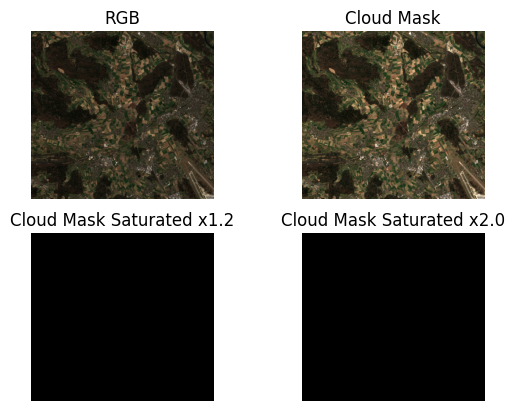

In [128]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(case_1_rgb)
axs[0, 0].set_title('RGB')
axs[0, 1].imshow(case_1_clm)
axs[0, 1].set_title('Cloud Mask')
axs[1, 0].imshow(case_1_csat)
axs[1, 0].set_title('Cloud Mask Saturated x1.2')
axs[1, 1].imshow(case_1_csat2)
axs[1, 1].set_title('Cloud Mask Saturated x2.0')

for ax in axs.flat:
    ax.set(xlabel='', ylabel='')
    ax.set_axis_off()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

##### 23.02.2021

|CC_API | CC_CLC |
| --- | --- |
| 0.02 | 22.20 |

In [ ]:
timestamp = '2021-02-23T10:37:44Z'